In [1]:
import tensorflow as tf
print(tf.__version__)
!pip list | grep waymo
!pip list | grep torch

2.0.0
waymo-open-dataset-tf-2-0-0 1.2.0
waymo-open-dataset-tf-2-1-0 1.2.0
torch                       1.5.0+cu101
torchvision                 0.6.0+cu101


In [2]:
!nvidia-smi

Sun May 31 09:38:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   33C    P0    34W / 250W |    263MiB / 12198MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import tensorflow.compat.v1 as tf
import math
import numpy as np
import itertools

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

import transforms as T
import utils
from PIL import Image
from glob import glob
import sys
import torch
import torch.utils.data as data

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import FasterRCNN

from engine import train_one_epoch, evaluate
import datetime
import os

In [40]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
#     if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


def loadWaymoTestFrames(PATH):
    #train_folders = ["training_0005","training_0004","training_0003","training_0002","training_0001","training_0000"]#["training_0001"]# ["training_0000", "training_0001"]
    #test_folders = ["testing_0007","testing_0006","testing_0005","testing_0004","testing_0003","testing_0002","testing_0001","testing_0000"]
    test_folders = ["testing_0000","testing_0001","testing_0002","testing_0003","testing_0004","testing_0005", "testing_0006", "testing_0007"]
    
    data_files = [path for x in test_folders for path in glob(os.path.join(PATH, x, "*.tfrecord"))]
    print(data_files)#all TFRecord file list
    print(len(data_files))
    dataset = [tf.data.TFRecordDataset(FILENAME, compression_type='') for FILENAME in data_files]#create a list of dataset for each TFRecord file
    frames = [] #store all frames = total number of TFrecord files * 40 frame(each TFrecord)
    for i, data_file in enumerate(dataset):
        print("Datafile: ",data_files[i])#Each TFrecord file
        for idx, data in enumerate(data_file): #Create frame based on Waymo API, 199 frames per TFrecord (20s, 10Hz)
#             if idx % 5 != 0: #Downsample every 5 images, reduce to 2Hz, total around 40 frames
#                 continue
            frame = open_dataset.Frame()
            frame.ParseFromString(bytearray(data.numpy()))
            frames.append(frame)
    return frames

In [41]:
def loadWaymoValidationFrames(PATH):
    #validation_folders = ["validation_0007","validation_0005","validation_0004","validation_0003","validation_0002","validation_0001","validation_0000"]
    #validation_folders = ["validation_0007","validation_0005","validation_0004","validation_0003"]#,"validation_0002","validation_0001","validation_0000"]
    validation_folders = ["validation_0000","validation_0001","validation_0002","validation_0003","validation_0004","validation_0005", "validation_0006", "validation_0007"]
    
    data_files = [path for x in validation_folders for path in glob(os.path.join(PATH, x, "*.tfrecord"))]
    print(data_files)#all TFRecord file list
    print(len(data_files))
    dataset = [tf.data.TFRecordDataset(FILENAME, compression_type='') for FILENAME in data_files]#create a list of dataset for each TFRecord file
    frames = [] #store all frames = total number of TFrecord files * 40 frame(each TFrecord)
    for i, data_file in enumerate(dataset):
        print("Datafile: ",i)#Each TFrecord file
        for idx, data in enumerate(data_file): #Create frame based on Waymo API, 199 frames per TFrecord (20s, 10Hz)
#             if idx % 5 != 0: #Downsample every 5 images, reduce to 2Hz, total around 40 frames
#                 continue
            frame = open_dataset.Frame()
            frame.ParseFromString(bytearray(data.numpy()))
            frames.append(frame)
    return frames

In [42]:
class myNewWaymoDataset(data.Dataset): #Inheritance of data.Dataset, torch.utils.data
    def __init__(self, root, waymoframes, transforms=None):
        self.label_map = {0:0, 1: 1, 2:2, 4:3} #4 object types (remove sign)
        self.root = root
        self.transforms = transforms
        self.frames = waymoframes
        del_indexes = []
        #filter out frames with small or no annotations
        for i, frame in enumerate(self.frames): #Total number of TFrecord files * (Each TFrecord file, 40 frames)
            #print("lkk frame num: ",i)
            target = {}
            target_bbox = []
            target_labels = []
            target_areas = []
        
            for camera_labels in frame.camera_labels: #5 cameras
                #print(open_dataset.CameraName.Name.Name(camera_labels.name))
                if camera_labels.name != 1: #Only use front camera
                    continue
                    
                for label in camera_labels.labels:                    
                    xmin= label.box.center_x - 0.5 * label.box.length
                    ymin = label.box.center_y - 0.5 * label.box.width
                    xmax = xmin + label.box.length
                    ymax = ymin + label.box.width
                    area = label.box.length * label.box.width
                    if xmin<=xmax and ymin<=ymax and xmin>=0 and ymin>=0 and xmax<=1920 and ymax<=1280:# and area>2000:
                        target_bbox.append([xmin, ymin, xmax, ymax])
                        target_labels.append(self.label_map[label.type])
                        target_areas.append(area)
                        if (label.type==3):#traffic sign
                            print("label.type==3")
                        if (label.type==0):#unknow
                            print("label.type==1")
                    else:
                        print("drop frame: ", i)
#                         print([label.box.center_x, label.box.center_y])
#                         print([label.box.length, label.box.width])
#                         print([xmin, ymin, xmax, ymax])
                        #print(self.frames[i].images.)
                    
#             target['boxes'] = torch.as_tensor(target_bbox, dtype=torch.float32)
#             target['labels'] = torch.as_tensor(np.array(target_labels), dtype=torch.int64)
#             target['image_id'] = torch.tensor([int(frame.context.name.split("_")[-2] + str(i))])
#             target["area"] = torch.as_tensor(target_areas, dtype=torch.float32)
#             target["iscrowd"] = torch.zeros((len(target['boxes'])), dtype=torch.int64)
            if len(target_bbox) > 0:
                #self.targets.append(target)
                testlabel=target_labels
                #print(target_labels)
                #print(len(target_bbox))
            else:
                print("no bbox, drop")
                del_indexes.append(i)
        
        for index in sorted(del_indexes, reverse=True):
            del self.frames[index] #delete frames without bounding box
        
#         for index in sorted(del_indexes, reverse=True):
#             del self.frames[index] #delete frames without bounding box

        
    def __getitem__(self, index):
        #self.frames: #Total number of TFrecord files * (Each TFrecord file, 40 frames)
        frameitem = self.frames[index]
        numimg=tf.image.decode_jpeg(frameitem.images[0].image).numpy()
        img = Image.fromarray(numimg).convert("RGB")
        #print(numimg.shape)#[1280 1920 3]
        imgwidth=numimg.shape[1]#1920
        imgheight=numimg.shape[0]#1280
        
        target = {}
        target_bbox = []
        target_labels = []
        target_areas = []
        for camera_labels in frameitem.camera_labels: #5 cameras
            #print(open_dataset.CameraName.Name.Name(camera_labels.name))
            if camera_labels.name != 1: #Only use front camera
                continue

            for label in camera_labels.labels:                    
                xmin= label.box.center_x - 0.5 * label.box.length
                ymin = label.box.center_y - 0.5 * label.box.width
                xmax = xmin + label.box.length
                ymax = ymin + label.box.width
                area = label.box.length * label.box.width
                
                if xmin<=xmax and ymin<=ymax and xmin>=0 and ymin>=0 and xmax<=imgwidth and ymax<=imgheight:# and area>2000 :
                    target_bbox.append([xmin, ymin, xmax, ymax])
                    target_labels.append(self.label_map[label.type])
                    target_areas.append(area)
#                 else:
#                     print("drop: ", index)
#                     print([label.box.center_x, label.box.center_y])
#                     print([label.box.length, label.box.width])
#                     print([xmin, ymin, xmax, ymax])
#                     print(area)
                    #print(self.frames[i].images.)

        target['boxes'] = torch.as_tensor(target_bbox, dtype=torch.float32)
        target['labels'] = torch.as_tensor(np.array(target_labels), dtype=torch.int64)
        target['image_id'] = torch.tensor([int(frameitem.context.name.split("_")[-2] + str(index))])
        target["area"] = torch.as_tensor(target_areas, dtype=torch.float32)
        target["iscrowd"] = torch.zeros((len(target['boxes'])), dtype=torch.int64)
                
        #target = self.targets[index]
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target #image and annotations

    def __len__(self):
        return len(self.frames) #return size

In [43]:
class myWaymoTestDataset(data.Dataset): #Inheritance of data.Dataset, torch.utils.data
    def __init__(self, root, waymotestframes, transforms=None):
        #self.label_map = {0:0, 1: 1, 2:2, 4:3} #4 object types (remove sign)
        self.root = root
        self.transforms = transforms
        self.frames = waymotestframes
        #del_indexes = []
        
    def __getitem__(self, index):
        #self.frames: #Total number of TFrecord files * (Each TFrecord file, 40 frames)
        frameitem = self.frames[index]
        numimg=tf.image.decode_jpeg(frameitem.images[0].image).numpy()
        img = Image.fromarray(numimg).convert("RGB")
        #print(numimg.shape)#[1280 1920 3]
        imgwidth=numimg.shape[1]#1920
        imgheight=numimg.shape[0]#1280
        
        print(frameitem.context.name)#Refer to dataset.proto for the data format. The context contains shared information among all frames in the scene.
        print(frameitem.timestamp_micros)
        
        return img#, target #image and annotations

    def __len__(self):
        return len(self.frames) #return size

In [27]:
def load_previous_object_detection_model(num_classes, modelpath):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    model.load_state_dict(torch.load(modelpath))

    return model

In [44]:
#model.load_state_dict(torch.load("saved_models/model_6.pth"))
num_classes = 4 #Unknown:0, Vehicles: 1, Pedestrians: 2, Cyclists: 3, Signs (removed)
model=load_previous_object_detection_model(num_classes,'./saved_models_mac1/model_39.pth') #./saved_models_py4/model_10.pth ./saved_models_mac1/model_27.pth


In [ ]:
PATH='/data/cmpe295-liu/Waymo'
waymotestframes=loadWaymoTestFrames(PATH)
mywaymotestdataset=myWaymoTestDataset(PATH, waymotestframes, get_transform(train=False))
#mywaymotestdataset = myNewWaymoDataset(PATH, waymotestframes, get_transform(train=False))
print("Total testing frames: ", len(mywaymotestdataset))

print("Loading Waymo validation frames...")
waymovalidationframes=loadWaymoValidationFrames(PATH)
mywaymovaldataset = myWaymoTestDataset(PATH, waymovalidationframes, get_transform(train=False))
print("Total validation frames: ", len(mywaymovaldataset))



['/data/cmpe295-liu/Waymo/testing_0000/segment-17792628511034220885_2360_000_2380_000_with_camera_labels.tfrecord', '/data/cmpe295-liu/Waymo/testing_0000/segment-10084636266401282188_1120_000_1140_000_with_camera_labels.tfrecord', '/data/cmpe295-liu/Waymo/testing_0000/segment-10149575340910243572_2720_000_2740_000_with_camera_labels.tfrecord', '/data/cmpe295-liu/Waymo/testing_0000/segment-10504764403039842352_460_000_480_000_with_camera_labels.tfrecord', '/data/cmpe295-liu/Waymo/testing_0000/segment-10980133015080705026_780_000_800_000_with_camera_labels.tfrecord', '/data/cmpe295-liu/Waymo/testing_0000/segment-11987368976578218644_1340_000_1360_000_with_camera_labels.tfrecord', '/data/cmpe295-liu/Waymo/testing_0000/segment-14188689528137485670_2660_000_2680_000_with_camera_labels.tfrecord', '/data/cmpe295-liu/Waymo/testing_0000/segment-14737335824319407706_1980_000_2000_000_with_camera_labels.tfrecord', '/data/cmpe295-liu/Waymo/testing_0000/segment-15272375112495403395_620_000_640_000_

In [17]:
waymotestframes=loadWaymoTestFrames(PATH)
mywaymotestdataset=myWaymoTestDataset(PATH, waymotestframes, get_transform(train=False))
#mywaymotestdataset = myNewWaymoDataset(PATH, waymotestframes, get_transform(train=False))
print("Total testing frames: ", len(mywaymotestdataset))

['/data/cmpe295-liu/Waymo/testing_0000/segment-17792628511034220885_2360_000_2380_000_with_camera_labels.tfrecord', '/data/cmpe295-liu/Waymo/testing_0000/segment-10084636266401282188_1120_000_1140_000_with_camera_labels.tfrecord', '/data/cmpe295-liu/Waymo/testing_0000/segment-10149575340910243572_2720_000_2740_000_with_camera_labels.tfrecord', '/data/cmpe295-liu/Waymo/testing_0000/segment-10504764403039842352_460_000_480_000_with_camera_labels.tfrecord', '/data/cmpe295-liu/Waymo/testing_0000/segment-10980133015080705026_780_000_800_000_with_camera_labels.tfrecord', '/data/cmpe295-liu/Waymo/testing_0000/segment-11987368976578218644_1340_000_1360_000_with_camera_labels.tfrecord', '/data/cmpe295-liu/Waymo/testing_0000/segment-14188689528137485670_2660_000_2680_000_with_camera_labels.tfrecord', '/data/cmpe295-liu/Waymo/testing_0000/segment-14737335824319407706_1980_000_2000_000_with_camera_labels.tfrecord', '/data/cmpe295-liu/Waymo/testing_0000/segment-15272375112495403395_620_000_640_000_

In [16]:
!rm /data/cmpe295-liu/Waymo/testing_0003/segment-1703056599550681101_4380_000_4400_000_with_camera_labels.tfrecord

In [30]:
# define training and validation data loaders
valdata_loader = torch.utils.data.DataLoader(
    mywaymovaldataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)


In [31]:
testdata_loader = torch.utils.data.DataLoader(
    mywaymotestdataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [32]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model to the right device
model.to(device)

evaluate(model, valdata_loader, device=device)

creating index...
index created!


/home/010796032/newvenv2/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Test:  [   0/1970]  eta: 6:45:50  model_time: 0.3013 (0.3013)  evaluator_time: 0.1686 (0.1686)  time: 12.3604  data: 11.8141  max mem: 2780
Test:  [ 100/1970]  eta: 0:20:53  model_time: 0.2832 (0.2848)  evaluator_time: 0.1463 (0.1570)  time: 0.5768  data: 0.0427  max mem: 2780
Test:  [ 200/1970]  eta: 0:17:59  model_time: 0.2830 (0.2847)  evaluator_time: 0.1432 (0.1555)  time: 0.5490  data: 0.0441  max mem: 2780
Test:  [ 300/1970]  eta: 0:16:28  model_time: 0.2823 (0.2844)  evaluator_time: 0.1713 (0.1563)  time: 0.5638  data: 0.0423  max mem: 2780
Test:  [ 400/1970]  eta: 0:15:17  model_time: 0.2808 (0.2839)  evaluator_time: 0.1119 (0.1590)  time: 0.5370  data: 0.0411  max mem: 2780
Test:  [ 500/1970]  eta: 0:14:09  model_time: 0.2795 (0.2834)  evaluator_time: 0.1331 (0.1577)  time: 0.5561  data: 0.0447  max mem: 2780
Test:  [ 600/1970]  eta: 0:13:06  model_time: 0.2823 (0.2834)  evaluator_time: 0.1053 (0.1580)  time: 0.5450  data: 0.0441  max mem: 2780
Test:  [ 700/1970]  eta: 0:12:06

# Visualize the test result

In [33]:
from matplotlib.pyplot import figure
from matplotlib.patches import Rectangle
%matplotlib inline

INSTANCE_Color = {
    'Unknown':'black', 'Vehicles':'red', 'Pedestrians':'green', 'Cyclists':'purple'
}#'Unknown', 'Vehicles', 'Pedestrians', 'Cyclists'

def show_image(image, pred_bbox, pred_labels):
    """Show a camera image and the given camera labels."""
        
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    boxnum=len(pred_bbox)
    #print(boxnum)
    print(pred_labels)
    for i in range(boxnum):#patch in pred_bbox:
        patch=pred_bbox[i]
        label=pred_labels[i]
        colorlabel=INSTANCE_Color[label]
        #print("patch:")
        #print(patch)#[(827.3006, 617.69965), (917.02795, 656.8029)]
        ax.add_patch(Rectangle(
        xy=patch[0],#(patch[0], patch[1]), #xmin ymin
        width=patch[1][0]-patch[0][0],#patch[2] - patch[0],
        height=patch[1][1]-patch[0][1],#patch[3] - patch[1],
        linewidth=1,
        edgecolor=colorlabel,#"red",
        facecolor='none'))
        ax.text(patch[0][0], patch[0][1], label, color=colorlabel, fontsize=8)
        #ax.text(patch[0][0], patch[0][1], label, bbox=dict(facecolor='red', alpha=0.5))#fontsize=8)
        
        
    ax.imshow(image)
    
    ax.title.set_text("Prediction")
    ax.grid(False)
    ax.axis('off')
    
    #fig.savefig(f"output/test_frame_{i}.png", dpi=fig.dpi)
#     plt.show()

In [34]:
label_map = {0:0, 1: 1, 2:2, 4:3}
score_threshold = 0.5

In [35]:
def get_dummy_target(frame, i):
    target = {}
    target['boxes'] = torch.as_tensor([[0.,0.,0.,0.]], dtype=torch.float32).to(device)
    target['labels'] = torch.as_tensor(np.array([[0]]), dtype=torch.int64).to(device)
    target['image_id'] = torch.tensor([int(frame.context.name.split("_")[-2] + str(i))]).to(device)
    target["area"] = torch.as_tensor([[0.]], dtype=torch.float32).to(device)
    target["iscrowd"] = torch.zeros((len(target['boxes'])), dtype=torch.int64).to(device)
    return target

In [36]:
##Unknown:0, Vehicles: 1, Pedestrians: 2, Cyclists: 3, Signs (removed)
INSTANCE_CATEGORY_NAMES = [
    'Unknown', 'Vehicles', 'Pedestrians', 'Cyclists'
]
def get_prediction(modeluse, image, threshold):
    target = {}
    target_bbox = []
    target_labels = []
    target_areas = []
    img, target = get_transform(train=False)(image, target)
    pred = modeluse([img.to(device)])
    #pred = modeluse.forward([img.to(device)], [target])
    #print(pred)
    #pred=pred.cpu().numpy()
    
    #img = Image.open(img_path) # Load the image
#     transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
#     img = transform(image) # Apply the transform to the image
#     pred = modeluse([img]) # Pass the image to the model
    
    pred_class = [INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())] # Get the Prediction Score
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())] # Bounding boxes
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    #print("Length: %d, %d, %d", len(pred_class), len(pred_boxes), len(pred_score))
    predlist=[pred_score.index(x) for x in pred_score if x > threshold] # Get list of index with score greater than threshold.
    #print(predlist)
    if len(predlist)>1:
        pred_t = predlist[-1] 
        pred_boxes = pred_boxes[:pred_t+1]
        pred_class = pred_class[:pred_t+1]
    else:
        print(pred_boxes)
        print(pred_class)
        maxpos = pred_score.index(max(pred_score))
        print("max position:", maxpos)
        pred_boxes = pred_boxes[maxpos:maxpos+1]#get the first one
        pred_class = pred_class[maxpos:maxpos+1]#get the first one
#         pred_boxes = pred_boxes[0]#get the first one
#         pred_class = pred_class[0]#get the first one
    
    #pred_boxes = [x.data.cpu().numpy() for idx, x in enumerate(pred[0]['boxes']) if pred[0]["scores"][idx] > score_threshold]
    #pred_class = [x.data.cpu().numpy() for idx, x in enumerate(pred[0]['labels']) if pred[0]["scores"][idx] > score_threshold]
    return pred_boxes, pred_class

10980133015080705026_780_000_800_000
1557159335448121
[[(1109.269, 632.7986), (1309.1605, 798.1503)], [(113.39028, 715.81244), (626.01544, 1008.779)], [(802.7045, 657.57385), (1025.7391, 851.9512)], [(3.352887, 860.4123), (178.45683, 1275.5426)], [(915.26416, 624.3298), (1014.14954, 699.096)], [(1068.2894, 628.8841), (1165.5161, 710.2876)], [(1372.8768, 614.9158), (1406.2899, 702.8935)], [(854.3206, 588.76685), (928.5835, 667.6469)], [(1742.5365, 662.0563), (1913.278, 767.4212)], [(595.4179, 602.3206), (642.4149, 714.42596)], [(683.7177, 606.5861), (720.3869, 687.5595)], [(649.5703, 604.08417), (683.2588, 683.3154)], [(1042.7616, 625.69617), (1113.4984, 691.85925)], [(1346.5408, 615.67255), (1381.6646, 702.6968)], [(558.74146, 603.14056), (597.3497, 683.1606)], [(1163.9242, 612.45355), (1230.2482, 641.3664)], [(718.5882, 600.3227), (745.78625, 685.5954)], [(775.6357, 612.99286), (798.5512, 677.91455)], [(551.0228, 600.4023), (579.4675, 680.5599)], [(1028.9562, 628.22925), (1059.9454, 6

/home/010796032/newvenv2/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


['Vehicles', 'Vehicles', 'Vehicles', 'Vehicles', 'Vehicles', 'Vehicles', 'Pedestrians', 'Vehicles', 'Vehicles', 'Pedestrians', 'Pedestrians', 'Pedestrians', 'Vehicles', 'Pedestrians', 'Pedestrians', 'Vehicles', 'Pedestrians', 'Pedestrians', 'Pedestrians', 'Vehicles', 'Vehicles', 'Vehicles', 'Pedestrians', 'Vehicles', 'Vehicles', 'Vehicles']
10980133015080705026_780_000_800_000
1557159337947154
[[(989.62854, 606.82855), (1123.9014, 717.1205)], [(1273.5302, 625.12384), (1409.7102, 719.24524)], [(823.96155, 600.30194), (1011.18085, 774.54083)], [(1227.6052, 607.03265), (1348.1443, 709.2093)], [(1104.5138, 629.0754), (1162.4393, 701.31146)], [(1190.9751, 610.719), (1261.1938, 697.928)], [(1595.9198, 605.3299), (1661.6578, 734.79346)], [(1153.5946, 631.5838), (1202.8829, 684.44073)], [(1661.1094, 606.23193), (1719.1614, 732.4717)], [(1517.0321, 604.0992), (1564.977, 726.60913)], [(555.9074, 603.7209), (595.4709, 713.34235)], [(464.28296, 617.2109), (522.4156, 759.1491)], [(600.5538, 612.630

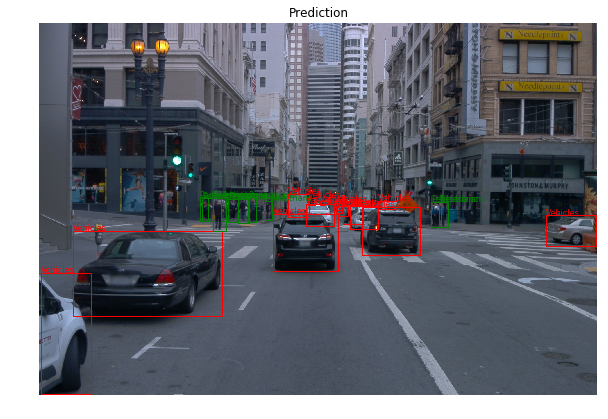

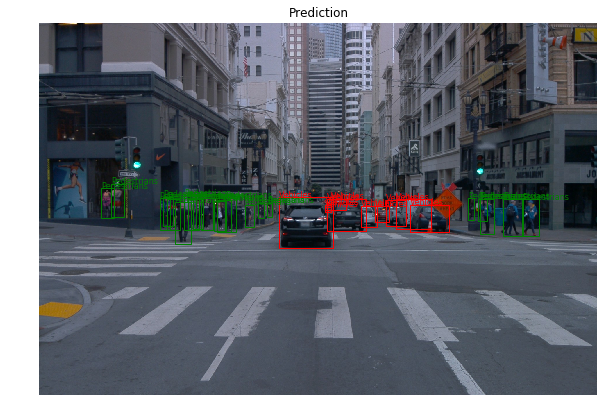

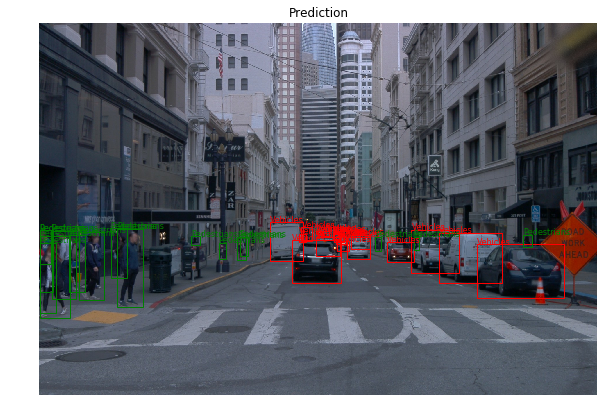

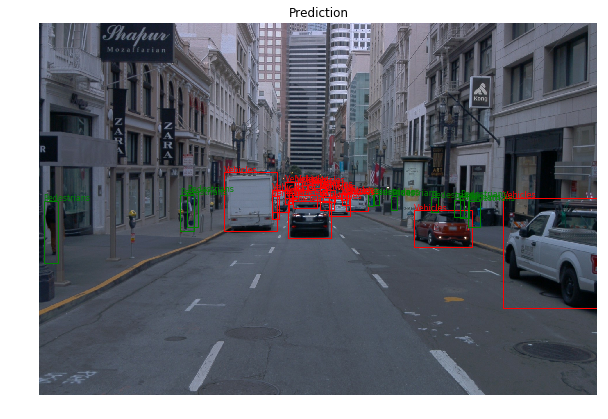

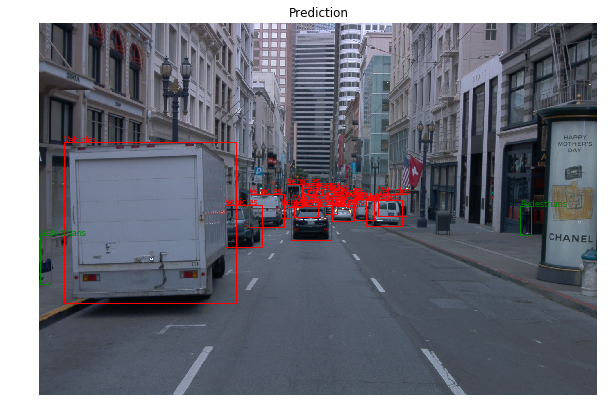

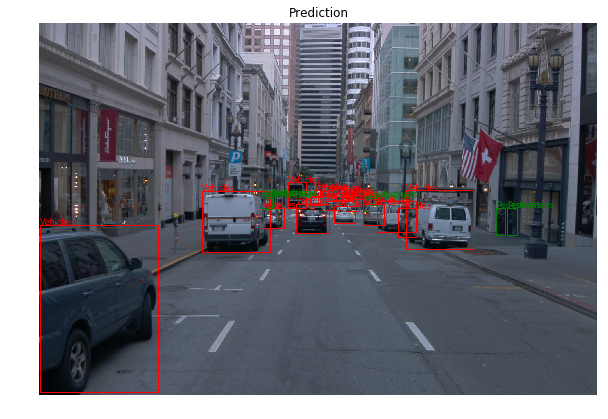

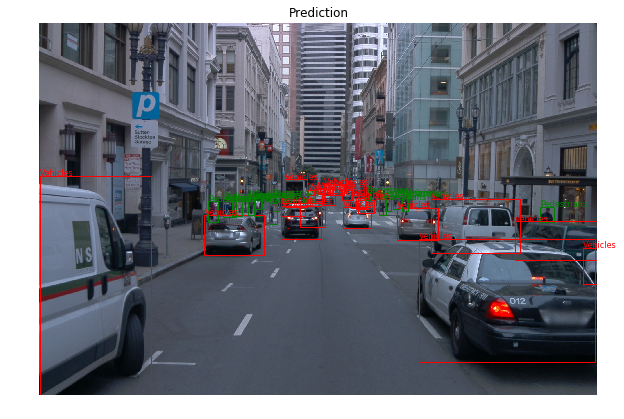

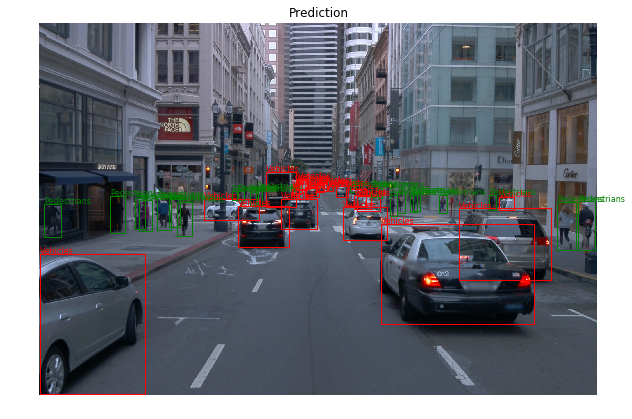

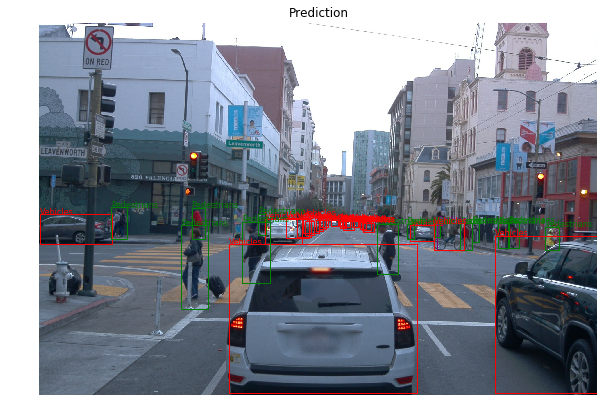

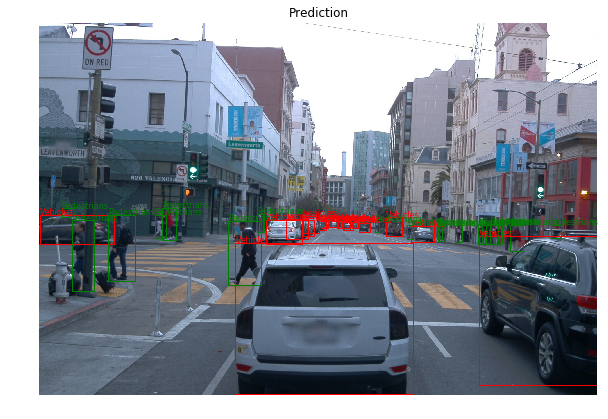

In [37]:
for i in range(30,40): #len(waymotestframes)
    step=5
    frame = waymotestframes[i*step]
    image = tf.image.decode_jpeg(frame.images[0].image).numpy()#front camera image
    
    #print(frame.camera_labels)#no labels
    print(frame.context.name)#Refer to dataset.proto for the data format. The context contains shared information among all frames in the scene.
    print(frame.timestamp_micros)
    img = Image.fromarray(image)
    
    boxes, pred_cls = get_prediction(model, img, score_threshold)
    print(boxes)
    print(pred_cls)
    show_image(image, boxes, pred_cls)
    
#     target = {}
#     target_bbox = []
#     target_labels = []
#     target_areas = []
    
    
    
#     target = get_dummy_target(frame,i)
#     target = get_dummy_target(frame,i)

#     img, target = get_transform(train=False)(img, target)
    
#     output = model.forward([img.to(device)], [target])
#     print("output:")
#     #print(output)
#     pred_bbox = [x.data.cpu().numpy() for idx, x in enumerate(output[0]['boxes']) if output[0]["scores"][idx] > score_threshold]
#     pred_labels = [x.data.cpu().numpy() for idx, x in enumerate(output[0]['labels']) if output[0]["scores"][idx] > score_threshold]
#     print(pred_bbox)
#     print(pred_labels)
#     show_image(image, pred_bbox, pred_labels)
#     pred = get_prediction(model, img, score_threshold)
#     print(pred)
#     for camera_labels in frame.camera_labels:

#         if camera_labels.name != 1: #only front camera
#             continue

#         for label in camera_labels.labels:                    
#             xmin= label.box.center_x - 0.5 * label.box.length
#             ymin = label.box.center_y - 0.5 * label.box.width
#             xmax = xmin + label.box.length
#             ymax = ymin + label.box.width
#             area = label.box.length * label.box.width
#             target_bbox.append([xmin, ymin, xmax, ymax])
#             target_labels.append(label_map[label.type])
#             target_areas.append(area)       
            
     
    

#     show_image(image, target_bbox, pred_bbox, i)